In [1]:
%matplotlib inline

In [76]:
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import auxfilter
import tools.matlabtools
import glob

In [3]:
from tools.bootstrap import *
# from pytools.signal import wavelets as mmwt
# lets = mmwt.CWTlets
# this is dodgy, please fix this

In [4]:
matplotlib.style.use('ggplot')

In [46]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slarge

Functions

In [6]:
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
           vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())
    
def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

Data loading section

In [7]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = tools.matlabtools.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [8]:
brief = data[:SR*120]
brief.shape

(48000, 16)

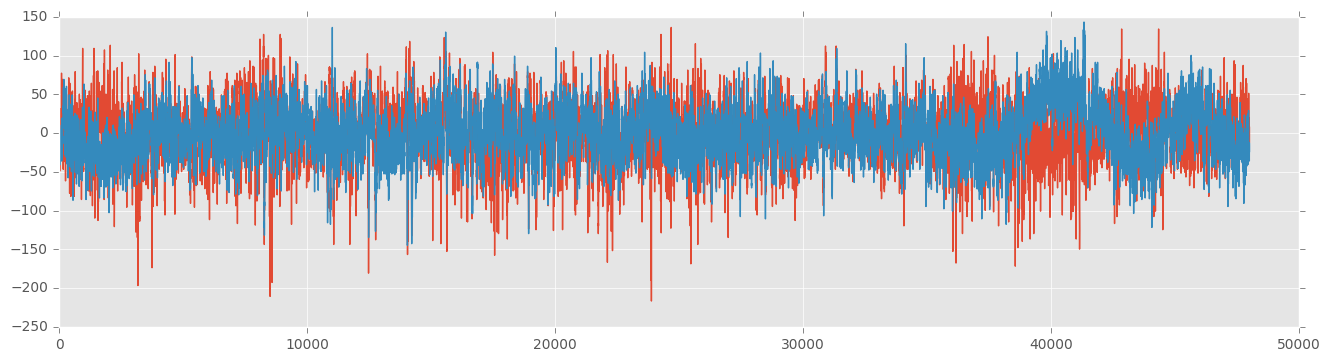

In [9]:
plt.plot(brief[:,:2])

In [10]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [11]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

In [14]:
data.shape

(240000, 16)

In [42]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
t = np.linspace(0, 400, len(fsig))

fsig.shape


(240000, 16)

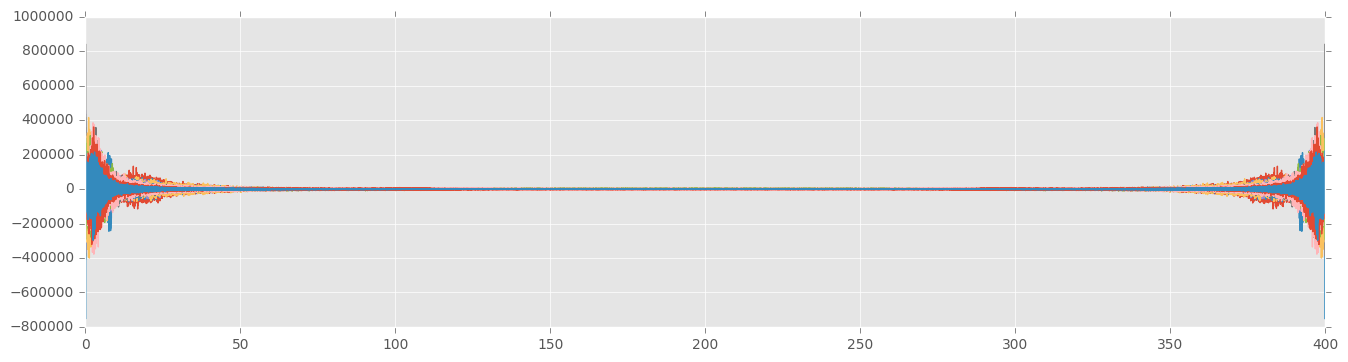

In [24]:
plt.plot(np.linspace(0, 400, len(fsig)), fsig)

In [28]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 


In [92]:
limit = 100
# dataset0 = [ tools.matlabtools.get_matlab_eeg_data(path)['data'] for path in sources0[:limit]]
# dataset1 = [ tools.matlabtools.get_matlab_eeg_data(path)['data'] for path in sources1[:limit]]
dataset0 = []
for path in sources0[:limit]:
    try:
        rawdata = tools.matlabtools.get_matlab_eeg_data(path)['data']
    except:
        print("DERP,", path)
    dataset0.append(rawdata)
    
for path in sources1[:limit]:
    try:
        rawdata = tools.matlabtools.get_matlab_eeg_data(path)['data']
    except:
        print("DERP,", path)
    dataset1.append(rawdata)


('DERP,', '/home/mike/Downloads/train_1/1_45_1.mat')


In [93]:
dataset0[0].shape

(240000, 16)

In [94]:
spectra = [ftpk.fft(datas, axis=0) for datas in dataset0]
spectra = np.array(spectra)
spectra1 = np.array([ftpk.fft(datas, axis=0) for datas in dataset1])
spectra.shape

(100, 240000, 16)

In [95]:
flat = np.average(spectra, axis=0)
flatstd = np.std(spectra, axis=0)
flat1 = np.average(spectra1, axis=0)
flatstd1 = np.std(spectra1, axis=0)
flat.shape

(240000, 16)

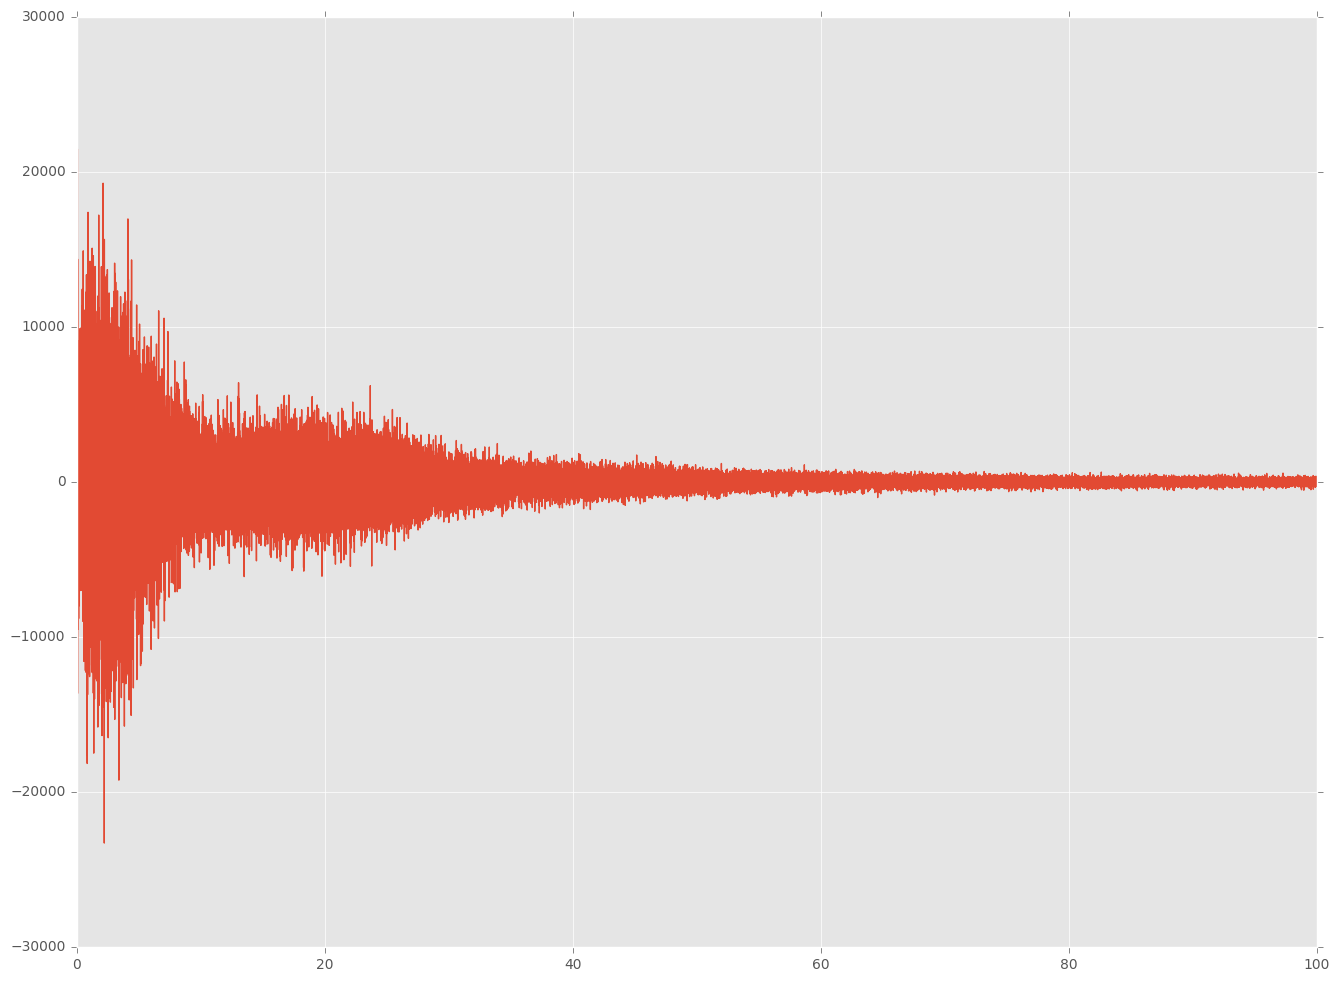

In [96]:
cut = 100*240000/400
tt = t[:cut]
plt.plot(t[:cut], flat[:cut,0])

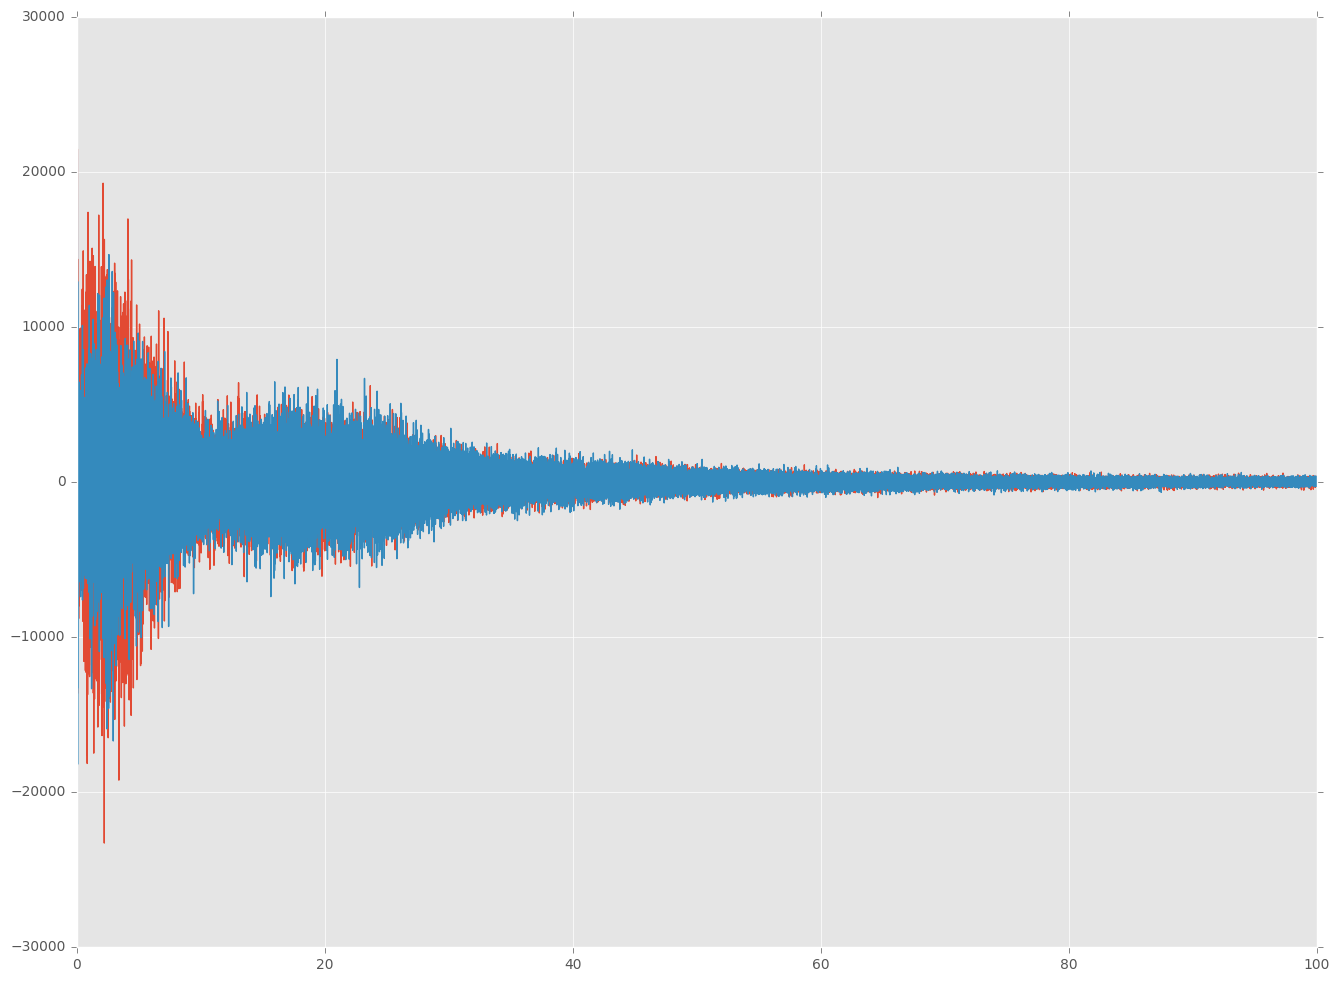

In [97]:
plt.plot(t[:cut], flat[:cut,0])
plt.plot(t[:cut], flat1[:cut,0])

60000

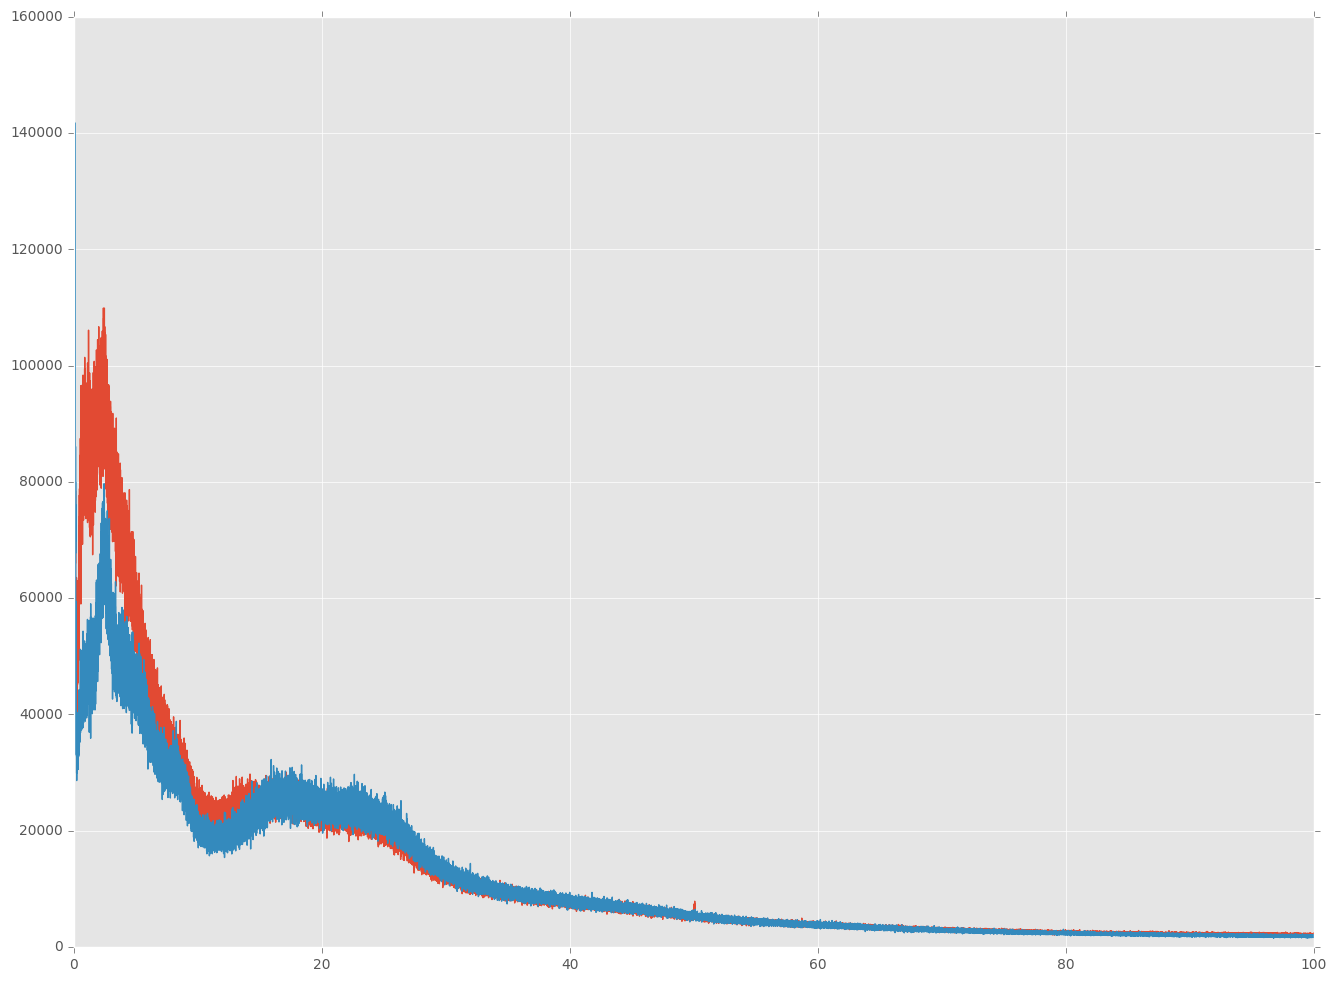

In [98]:
plt.plot(t[:cut], flatstd[:cut,0])
plt.plot(t[:cut], flatstd1[:cut,0])
len(t[:cut])

In [99]:
len(t)/400

600

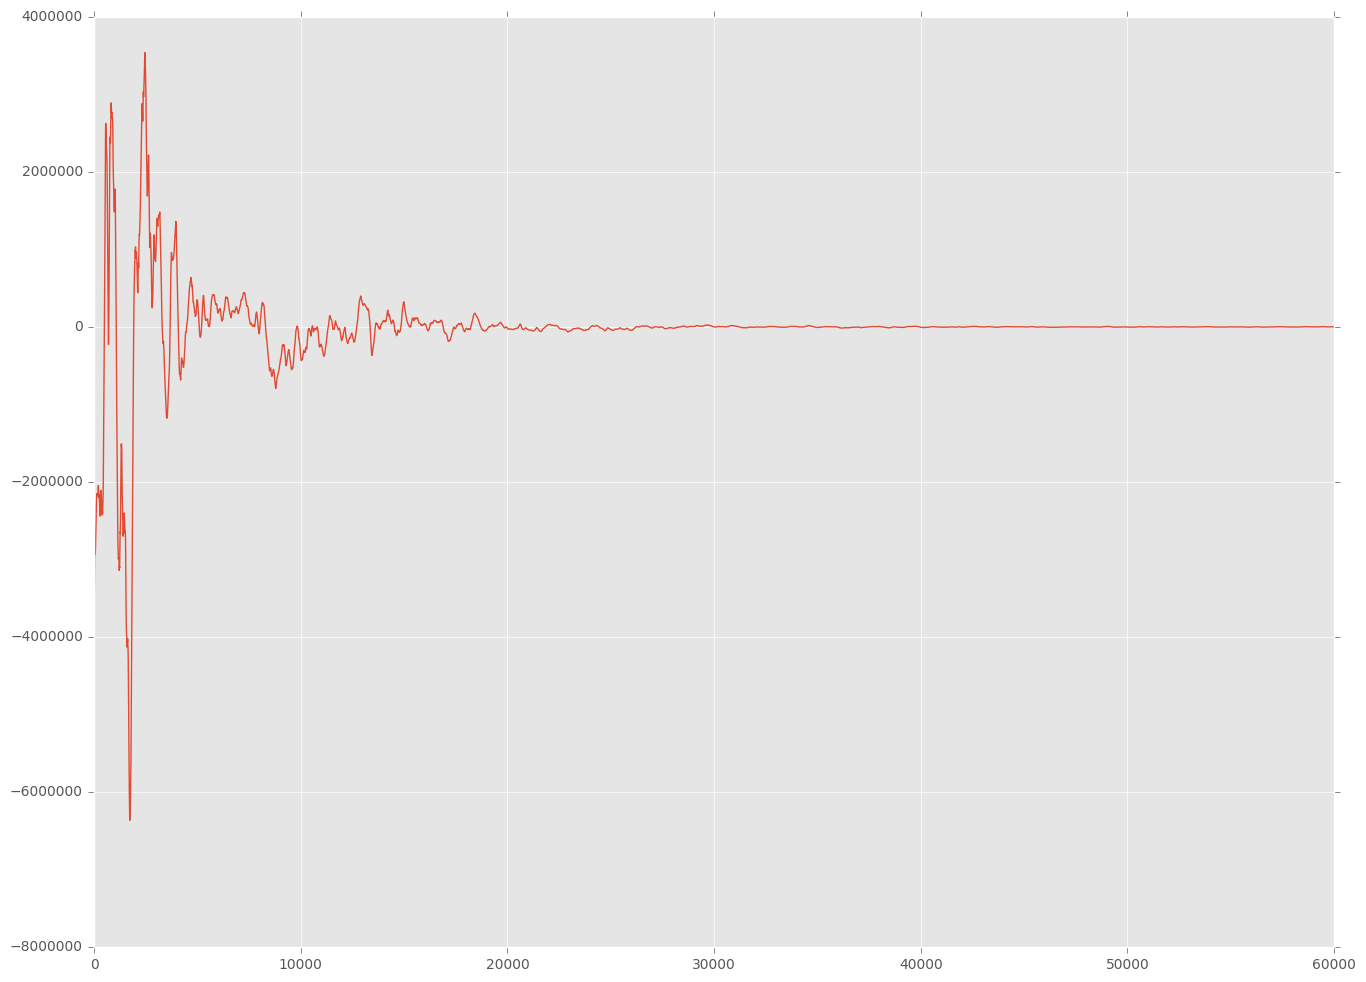

In [100]:
lp_flat0 = auxfilter.butterfilt(flat[:cut,0]**2, .5, 400)
plt.plot(lp_flat0)

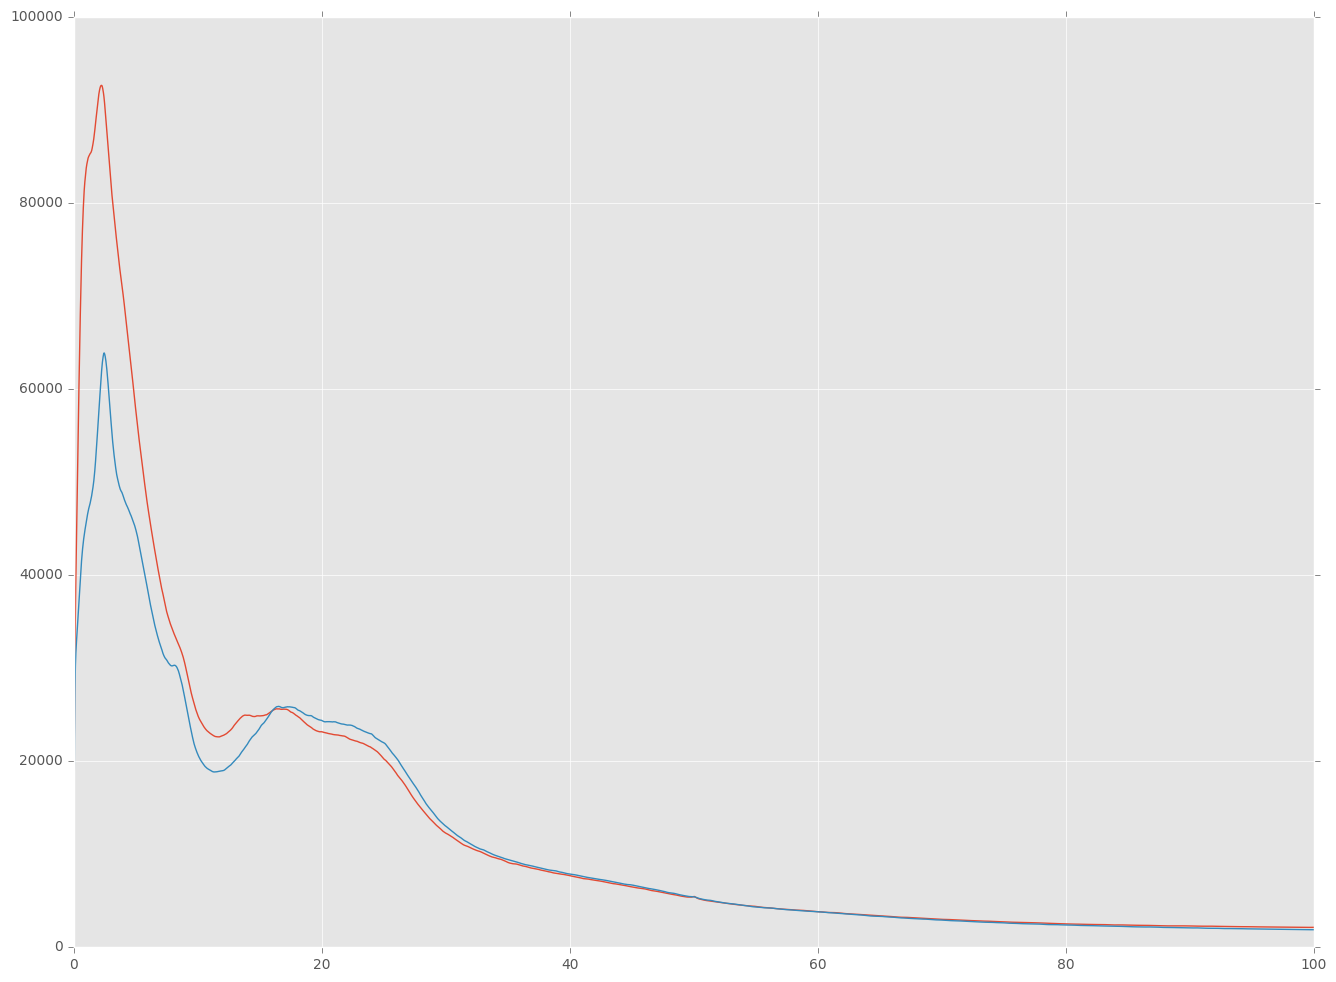

In [102]:
lp_flat0 = auxfilter.butterfilt(flatstd[:cut,0], .5, 400)
lp_flat1 = auxfilter.butterfilt(flatstd1[:cut,0], .5, 400)

plt.plot(tt, lp_flat0)
plt.plot(tt, lp_flat1)

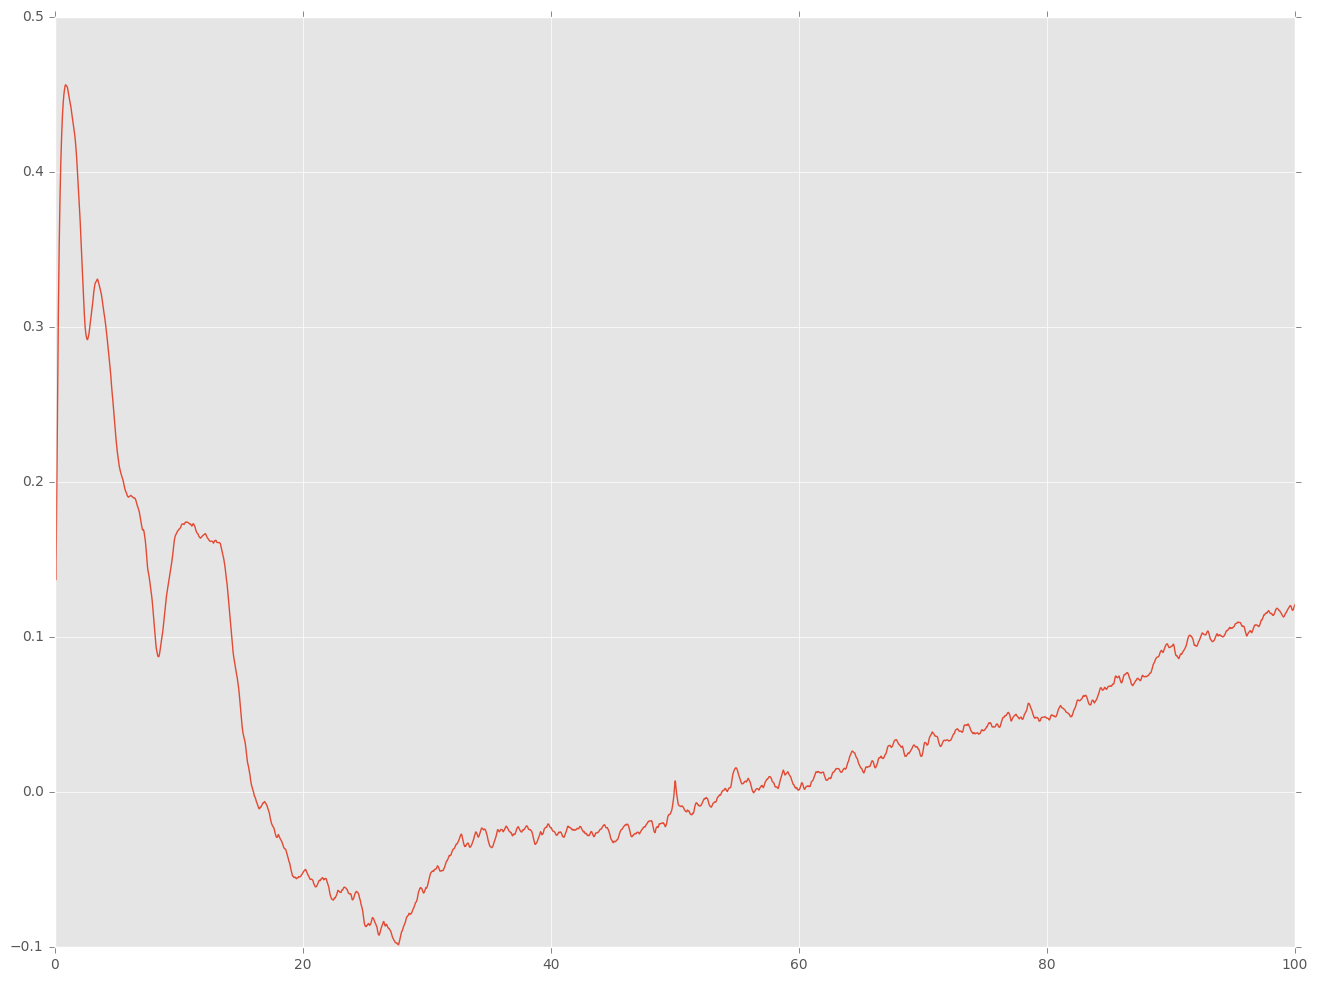

In [104]:
plt.plot(tt, (lp_flat0-lp_flat1)/lp_flat0)

Keras layer structure
option 1: take FFT, concat all the electrodes, feed into MLP (sigmoid). Dense 3 layer, 1-hot output. 
linearity bad. Reduce features (pca, smoothing, manual decimation) 
option 2: same, but with convo, max pooling instead of dimensionality reduction
option 3: noob feature vector maker (1600 per slice). feed into MLP as above.
option 4: NFV and use deep belief network (needs extensions)